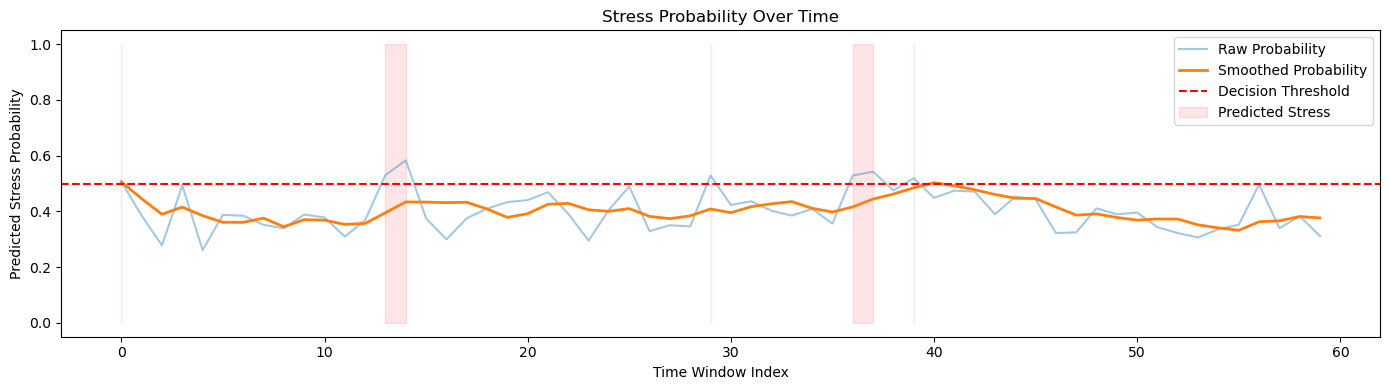

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Simulate stress features and labels for the Stress State Layer
np.random.seed(42)
n_samples = 300
time_index = np.arange(n_samples)

# Simulated features: ECG RMSSD, Breath rate, EDA slope, EDA mean
X_simulated = np.random.randn(n_samples, 4)

# Simulated binary labels: 0=baseline, 1=stress
y_simulated = np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_simulated, y_simulated, test_size=0.2, random_state=42, stratify=y_simulated)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Classifier (logistic regression for simplicity)
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
y_pred = clf.predict(X_test_scaled)

# Map predictions back to timeline
timeline_df = pd.DataFrame({
    "Time": time_index[:len(y_pred)],
    "TrueLabel": y_test,
    "PredictedProb": y_pred_proba,
    "PredictedClass": y_pred
})

# Smoothing predictions (rolling average)
timeline_df["SmoothedProb"] = timeline_df["PredictedProb"].rolling(window=5, min_periods=1).mean()

# Plot timeline of predictions
plt.figure(figsize=(14, 4))
plt.plot(timeline_df["Time"], timeline_df["PredictedProb"], label='Raw Probability', alpha=0.4)
plt.plot(timeline_df["Time"], timeline_df["SmoothedProb"], label='Smoothed Probability', linewidth=2)
plt.axhline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.fill_between(timeline_df["Time"], 0, 1, where=(timeline_df["PredictedClass"] == 1), alpha=0.1, color='red', label='Predicted Stress')
plt.title("Stress Probability Over Time")
plt.xlabel("Time Window Index")
plt.ylabel("Predicted Stress Probability")
plt.legend()
plt.tight_layout()
plt.savefig("SL.png", dpi=300, bbox_inches='tight')
plt.show()

#import ace_tools as tools; tools.display_dataframe_to_user(name="Stress Prediction Timeline", dataframe=timeline_df.round(3))


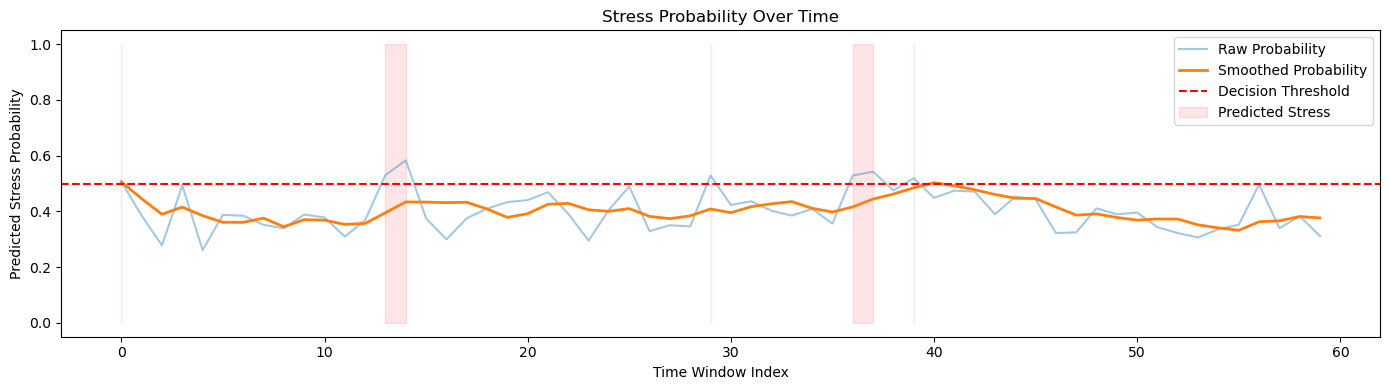

In [9]:
# Ensure correct data type for plotting
timeline_df["Time"] = timeline_df["Time"].astype(float)
timeline_df["PredictedClass"] = timeline_df["PredictedClass"].astype(int)

# Plot timeline of predictions with correction
plt.figure(figsize=(14, 4))
plt.plot(timeline_df["Time"], timeline_df["PredictedProb"], label='Raw Probability', alpha=0.4)
plt.plot(timeline_df["Time"], timeline_df["SmoothedProb"], label='Smoothed Probability', linewidth=2)
plt.axhline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.fill_between(timeline_df["Time"], 0, 1, where=(timeline_df["PredictedClass"] == 1).values, alpha=0.1, color='red', label='Predicted Stress')
plt.title("Stress Probability Over Time")
plt.xlabel("Time Window Index")
plt.ylabel("Predicted Stress Probability")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# 👇 Example input dataframe structure (must already exist)
# timeline_df should have: "Time", "PredictedProb", "SmoothedProb", "PredictedClass", "TrueLabel"

# Extract arrays
time_arr = timeline_df["Time"].to_numpy(dtype=float)
prob_arr = timeline_df["PredictedProb"].to_numpy(dtype=float)
smooth_arr = timeline_df["SmoothedProb"].to_numpy(dtype=float)
predicted_mask = timeline_df["PredictedClass"].to_numpy(dtype=int) == 1
ground_truth_mask = timeline_df["TrueLabel"].to_numpy(dtype=int) == 1

# 1️⃣ Bootstrapped Confidence Interval
def bootstrap_ci(data, n=200, ci=95):
    stats = []
    for _ in range(n):
        sample = resample(data)
        stats.append(np.mean(sample))
    lower = np.percentile(stats, (100 - ci) / 2)
    upper = np.percentile(stats, 100 - (100 - ci) / 2)
    return lower, upper

ci_lower, ci_upper = [], []
rolling_window = 5
for i in range(len(prob_arr)):
    segment = prob_arr[max(0, i - rolling_window):i + 1]
    low, high = bootstrap_ci(segment)
    ci_lower.append(low)
    ci_upper.append(high)

ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)

# 2️⃣ Plot
plt.figure(figsize=(15, 5))
plt.plot(time_arr, prob_arr, label='Raw Probability', alpha=0.3, color='orange')
plt.plot(time_arr, smooth_arr, label='Smoothed Probability', linewidth=2, color='darkorange')
plt.fill_between(time_arr, ci_lower, ci_upper, color='orange', alpha=0.2, label='95% CI (Bootstrapped)')

# Decision threshold line
plt.axhline(0.5, linestyle='--', color='red', label='Decision Threshold')

# Shaded stress predictions (red)
plt.fill_between(time_arr, 0, 1, where=predicted_mask, color='red', alpha=0.1, label='Predicted Stress')

# Shaded ground truth stress (blue)
plt.fill_between(time_arr, 0, 1, where=ground_truth_mask, color='blue', alpha=0.1, label='Ground Truth Stress')

# 3️⃣ Optional Annotation
if np.any(predicted_mask):
    spike_idx = np.argmax(prob_arr)
    plt.annotate("Stress spike", xy=(time_arr[spike_idx], prob_arr[spike_idx]),
                 xytext=(time_arr[spike_idx] + 1, prob_arr[spike_idx] + 0.1),
                 arrowprops=dict(arrowstyle="->", color="black"))

# Labels & layout
plt.title("Enhanced Stress Probability Timeline with Annotations")
plt.xlabel("Time Window Index")
plt.ylabel("Predicted Stress Probability")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


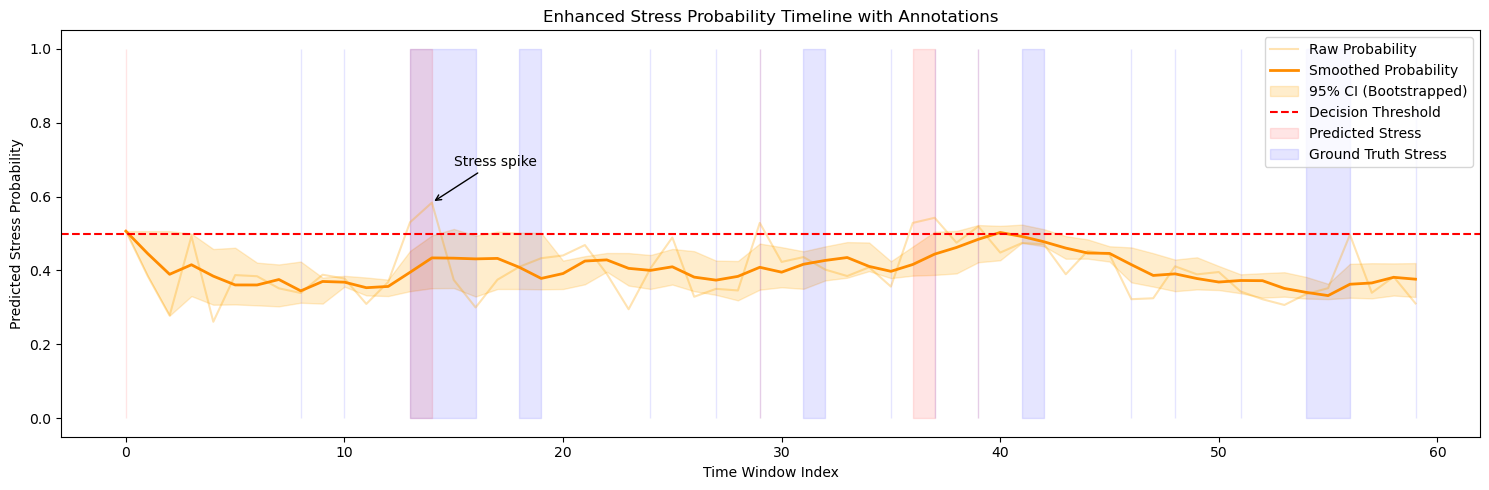

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

#  Example input dataframe structure (must already exist)
# timeline_df should have: "Time", "PredictedProb", "SmoothedProb", "PredictedClass", "TrueLabel"

# Extract arrays
time_arr = timeline_df["Time"].to_numpy(dtype=float)
prob_arr = timeline_df["PredictedProb"].to_numpy(dtype=float)
smooth_arr = timeline_df["SmoothedProb"].to_numpy(dtype=float)
predicted_mask = timeline_df["PredictedClass"].to_numpy(dtype=int) == 1
ground_truth_mask = timeline_df["TrueLabel"].to_numpy(dtype=int) == 1

# 1️Bootstrapped Confidence Interval
def bootstrap_ci(data, n=200, ci=95):
    stats = []
    for _ in range(n):
        sample = resample(data)
        stats.append(np.mean(sample))
    lower = np.percentile(stats, (100 - ci) / 2)
    upper = np.percentile(stats, 100 - (100 - ci) / 2)
    return lower, upper

ci_lower, ci_upper = [], []
rolling_window = 5
for i in range(len(prob_arr)):
    segment = prob_arr[max(0, i - rolling_window):i + 1]
    low, high = bootstrap_ci(segment)
    ci_lower.append(low)
    ci_upper.append(high)

ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)

# 2️ Plot
plt.figure(figsize=(15, 5))
plt.plot(time_arr, prob_arr, label='Raw Probability', alpha=0.3, color='orange')
plt.plot(time_arr, smooth_arr, label='Smoothed Probability', linewidth=2, color='darkorange')
plt.fill_between(time_arr, ci_lower, ci_upper, color='orange', alpha=0.2, label='95% CI (Bootstrapped)')

# Decision threshold line
plt.axhline(0.5, linestyle='--', color='red', label='Decision Threshold')

# Shaded stress predictions (red)
plt.fill_between(time_arr, 0, 1, where=predicted_mask, color='red', alpha=0.1, label='Predicted Stress')

# Shaded ground truth stress (blue)
plt.fill_between(time_arr, 0, 1, where=ground_truth_mask, color='blue', alpha=0.1, label='Ground Truth Stress')

# 3️Optional Annotation
if np.any(predicted_mask):
    spike_idx = np.argmax(prob_arr)
    plt.annotate("Stress spike", xy=(time_arr[spike_idx], prob_arr[spike_idx]),
                 xytext=(time_arr[spike_idx] + 1, prob_arr[spike_idx] + 0.1),
                 arrowprops=dict(arrowstyle="->", color="black"))

# Labels & layout
plt.title("Enhanced Stress Probability Timeline with Annotations")
plt.xlabel("Time Window Index")
plt.ylabel("Predicted Stress Probability")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
